In [14]:
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

# Init

In [15]:
import scipy.io
import os
import random
import numpy as np
import scipy
import os.path
import pickle
import gzip
import csv
import scipy.optimize as sciopt
import scipy.integrate as sciint

import pylab as plt
from pylab import subplot,subplot2grid,figure,plot,matshow
%matplotlib inline

In [16]:
# cuts dataset into those where the input vectors have a certain norm smaller equal to cut and the rest
def cutDataSetNorm(inputs,outputs, cut,norm):
    sel = np.linalg.norm(inputs,ord=norm,axis=1) <= cut
    # sel = np.array([not(all(x<=cut) and all(x>=-cut)) for x in inputs])
    return ((inputs[sel], outputs[sel]),(inputs[np.logical_not(sel)], outputs[np.logical_not(sel)]))

In [17]:
# cuts dataset into those where the input vectors along the given dimensions have a certain norm smaller equal to cut and the rest
def cutDataSetNormDim(inputs,outputs, dims, cut,norm):
    sel = np.linalg.norm(inputs[:,dims],ord=norm,axis=1) <= cut
    return ((inputs[sel], outputs[sel]),(inputs[np.logical_not(sel)], outputs[np.logical_not(sel)]))
# cuts dataset into those where the all input coordinates along the given dimensions are below a threshold
def cutDataSetTreshDim(inputs,outputs, dims, cut):
    sel = np.max(inputs[:,dims],axis=1) <= cut
    return ((inputs[sel], outputs[sel]),(inputs[np.logical_not(sel)], outputs[np.logical_not(sel)]))

In [18]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / N

In [19]:
def smoothen_gauss(x,sigma): 
    l = min(len(x),25)
    k=np.arange(l/2*2-1)-(l/2-1)
    gaussian = np.exp(-(k/sigma)**2/2)
    gaussian /= np.sum(gaussian)
    return np.convolve(x, gaussian, mode="same")

In [20]:
def stats(d):
    return { 'len' : len(d),
             'mean': np.mean(d, axis=0),
             'std': np.std(d, axis=0),
             'min': np.min(d, axis=0),
             'max': np.max(d, axis=0),
    }     

In [21]:
def splitDataSetNoTest(inputs,outputs):
    assert len(inputs) == len(outputs)
    size=len(inputs)
    ts=size*90//100
    train_set=(inputs[:ts],outputs[:ts])
    valid_set=(inputs[ts:],outputs[ts:])
    return train_set, valid_set

In [22]:
def computeFilteredSignals(datadict, dt=0.01, smoothing=3):
    datadict['fq1'] = smoothen_gauss(datadict['q1'],0.5)[1:]
    dq_s=smoothen_gauss(datadict['dq1'],smoothing)
    datadict['fdq1'] = dq_s[1:]
    ddq = (dq[1:]-dq[:-1])/dt
    ddq_s=smoothen_gauss(ddq,smoothing)
    datadict['fddq1'] = ddq_s
    dpr1 = (dat['pr1'][1:]-dat['pr1'][:-1])/dt
    datadict['fdpr1'] = smoothen_gauss(dpr1,smoothing)
    dpr2 = (dat['pr2'][1:]-dat['pr2'][:-1])/dt
    datadict['fdpr2'] = smoothen_gauss(dpr2,smoothing)
    
    datadict['pr1des'] = datadict['pr1des'][1:]
    datadict['pr2des'] = datadict['pr2des'][1:]
    

# Dataset Manipulator Arm

In [23]:
import DL.utils.data_loading as data_loading
import DL.utils.data_splitting as data_splitting
import DL.utils.standardizer as standardizer

In [24]:
def default_load(file_name, seed = 1):
    np.random.seed(seed)    
    observations, actions = data_loading.loadRobotData(file_name)    
    print(observations.shape)
    return observations, actions

In [25]:
np.random.choice(range(10),4, replace=False)

array([4, 7, 9, 0])

In [26]:
def load_training(file_name, hist_len = 1, horizon=1, average=False):
    np.random.seed(42)    
    observations, actions = data_loading.loadRobotData(file_name)
    print(observations.shape)
    num_rollouts = len(observations)
    val_rollouts_idx = np.random.choice(range(num_rollouts),num_rollouts//5, replace=False)
    train_rollouts_idx= np.setdiff1d(np.arange(num_rollouts), val_rollouts_idx)
    print(len(train_rollouts_idx), len(val_rollouts_idx))
    print(train_rollouts_idx)
    
    train_targets, train_inputs = data_loading.unrollTrainingData(observations[train_rollouts_idx], 
                                                                  actions[train_rollouts_idx], 
                                                                  history_len=hist_len,
                                                                  prediction_horizon=horizon,
                                                                  difference_learning=True,
                                                                  average = average)
    print("Train Inputs:", train_inputs.shape)
    print("Train Targets:", train_targets.shape)
    val_targets, val_inputs = data_loading.unrollTrainingData(observations[val_rollouts_idx], 
                                                              actions[val_rollouts_idx], 
                                                              history_len=hist_len,
                                                              prediction_horizon=horizon,
                                                              difference_learning=True,
                                                              average = average)
    
    print("Val Inputs:", val_inputs.shape)
    print("Val Targets:", val_targets.shape)
    
    return (train_inputs, train_targets), (val_inputs, val_targets)

## Small dataset

In [141]:
# train_all_small,test_small = default_load("Dataset/dataset_v01.npz")
observations, actions = default_load("Dataset/dataset_v01.npz")

(10, 5000, 9)


In [322]:
inputs = observations[0]
targets = actions[0]

In [293]:
inputs = train_all_small[0]
targets = train_all_small[1]

In [244]:
np.set_printoptions(suppress=True)
stats(inputs)

{'len': 39992,
 'mean': array([ 0.00616281, -0.0003996 , -0.01122306,  1.65883169,  1.363879  ,
         2.18319796, -0.00905951,  0.04285348, -0.22793385,  0.00611656,
        -0.00043915, -0.01111953]),
 'std': array([0.13284433, 0.10233731, 0.11865403, 0.76800887, 0.53812155,
        1.89855349, 4.7603251 , 3.54471587, 8.23723498, 0.12823738,
        0.09860279, 0.11239662]),
 'min': array([ -0.36      ,  -0.36      ,  -0.36      ,  -0.20455191,
         -0.07064809,  -0.03975263, -19.18683978, -15.04366298,
        -41.00852237,  -0.37170164,  -0.38052461,  -0.37290387]),
 'max': array([ 0.36      ,  0.36      ,  0.36      ,  2.99613729,  2.81557646,
         5.7268222 , 18.12378494, 13.20848561, 32.92957631,  0.37619539,
         0.3509604 ,  0.47400581])}

In [93]:
train_small, valid_small = splitDataSetNoTest(*train_all_small)

In [94]:
pickle.dump((train_small,valid_small,test_small), gzip.open("Dataset/dataset_v01_split.dat.gz", "wb"), protocol=2)

## Big Dataset

In [114]:
# train_all,test = default_load("Dataset/dataset_v02.npz")
observations, actions= default_load("Dataset/dataset_v02_training.npz")

(152, 19000, 9)


In [115]:
inputs = np.concatenate(observations, axis=0)
targets = np.concatenate(actions, axis=0)
inputs.shape

(2888000, 9)

In [144]:
train,val = load_training("Dataset/dataset_v02_training.npz", hist_len=1, horizon=1)

(152, 19000, 9)
122 30
[  0   1   2   3   4   5   6   7   8  10  11  13  14  16  17  20  21  22
  23  24  25  27  28  29  32  33  34  35  37  38  39  40  41  43  44  45
  46  47  48  49  50  51  52  53  54  55  57  58  59  61  62  63  64  66
  70  71  72  73  74  75  76  77  78  79  80  81  83  84  85  87  88  89
  90  91  92  93  94  95  97  98  99 100 101 102 103 104 105 106 107 109
 110 111 114 116 117 118 119 120 121 122 123 124 125 127 129 130 131 132
 133 136 137 140 141 142 143 144 145 146 148 149 150 151]
Train Inputs: (2317878, 12)
Train Targets: (2317878, 9)
Val Inputs: (569970, 12)
Val Targets: (569970, 9)


In [145]:
inputs_raw = train[0]
targets_raw = train[1]

## some plots

In [146]:
np.set_printoptions(suppress=True)
stats(inputs_raw)

{'len': 2317878,
 'mean': array([ 0.00011336,  0.00008691,  0.00022613,  1.71783091,  1.43183034,
         2.9815556 ,  0.00073124, -0.0005259 , -0.00137372,  0.00008339,
         0.00010098,  0.00022565]),
 'std': array([0.08874948, 0.08857212, 0.08859234, 0.14113569, 0.17113888,
        0.81693716, 1.61107264, 1.27295662, 2.50034759, 0.07333273,
        0.07414337, 0.07463184]),
 'min': array([ -0.36      ,  -0.36      ,  -0.36      ,   0.52184101,
         -0.03265793,  -0.09802164, -20.8070196 , -16.33746131,
        -28.91590126,  -0.46097955,  -0.47546219,  -0.39359181]),
 'max': array([ 0.36      ,  0.36      ,  0.36      ,  2.89923135,  2.79904764,
         5.6686737 , 19.35126362, 14.2164255 , 34.2594258 ,  0.45591725,
         0.47679574,  0.46656326])}

In [147]:
stats(targets_raw)

{'len': 2317878,
 'mean': array([ 0.00000071, -0.00000048, -0.00000142, -0.00001857,  0.00000025,
        -0.00001467, -0.00000049, -0.00000027,  0.00000006]),
 'std': array([0.00170057, 0.00135226, 0.00264658, 0.27115563, 0.25568089,
        0.22324234, 0.03081422, 0.03007038, 0.03761667]),
 'min': array([-0.03441745, -0.02538592, -0.05840853, -5.81313762, -5.4658094 ,
        -8.40727083, -0.53704682, -0.480482  , -0.5618894 ]),
 'max': array([0.03884603, 0.02517669, 0.06653342, 6.43133984, 6.66821485,
        3.69255053, 0.53990447, 0.46947164, 0.56151681])}

In [148]:
input_stdizer = standardizer.Standardizer(data=inputs_raw)
inputs = input_stdizer.standardize(inputs_raw)

target_stdizer = standardizer.Standardizer(data=targets_raw)
targets = target_stdizer.standardize(targets_raw)

In [40]:
stats(targets)

{'len': 2317878,
 'mean': array([-0., -0.,  0.,  0.,  0.,  0., -0.,  0., -0.]),
 'std': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'min': array([-20.23924069, -18.77259273, -22.06887215, -21.43831223,
        -21.37746657, -37.65977392, -17.42852425, -15.97857151,
        -14.93724608]),
 'max': array([22.8425914 , 18.61858609, 25.13990107, 23.71832894, 26.08022299,
        16.54061303, 17.52129404, 15.61243636, 14.92733785])}

In [180]:
rollout = 30
window = slice(rollout,2000*122+rollout, 122)
def shift_slice(s, n):
    return slice(s.start+n, s.stop+n, s.step)

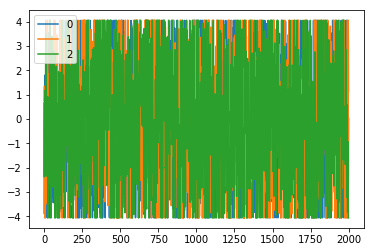

In [181]:
for k in [0,1,2,]:
    plt.plot(inputs[window, k], label=k)
plt.legend()

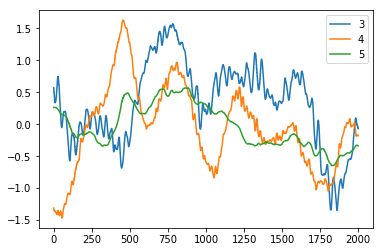

In [182]:
for k in [3,4,5,]:
    plt.plot(inputs[window, k], label=k)
plt.legend()

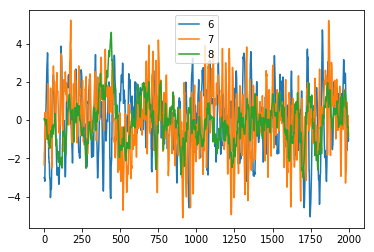

In [183]:
for k in [6,7,8,]:
    plt.plot(inputs[window, k], label=k)
plt.legend()

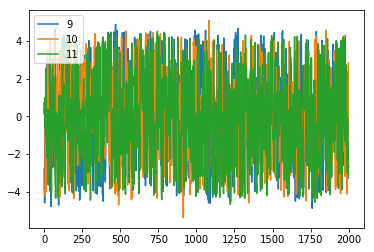

In [184]:
for k in [9,10,11,]:
    plt.plot(inputs[window, k], label=k)
plt.legend()

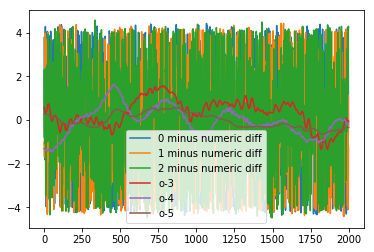

In [185]:
for k in [0,1,2]:
    plt.plot((inputs[shift_slice(window,1), k] - inputs[window, k]), label=str(k) + " minus numeric diff")
for k in [3,4,5,]:
    plt.plot(inputs[window, k], label="o-" + str(k))
plt.legend()

In [172]:
plt.figure(figsize=(12,8))
for k in [3,4,5]:
    dat = (inputs[shift_slice(window,10), k] - inputs[window, k])/10
    q0_s=smoothen_gauss(dat,2)
    plt.plot(dat, label=str(k) + " numeric diff")
for k in [6,7,8]:
    plt.plot(inputs[window, k], label=str(k))
plt.legend()

NameError: name 'smoothen_gauss' is not defined

<Figure size 864x576 with 0 Axes>

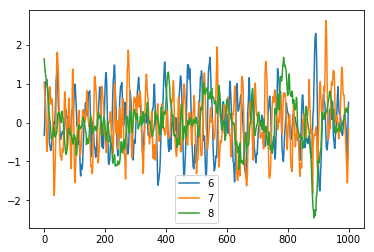

In [173]:
for k in [6,7,8]:
    plt.plot(inputs[window, k], label=k)
plt.legend()

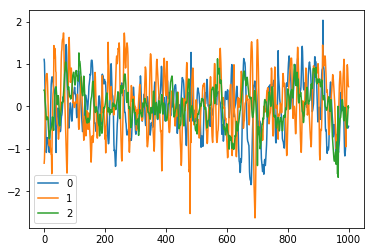

In [174]:
for k in range(3):
    plt.plot(targets[shift_slice(window,-1), k], label=k)
plt.legend()

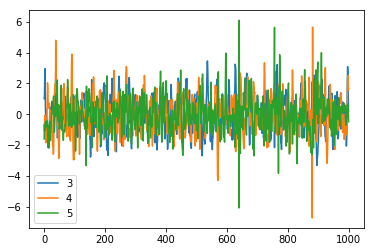

In [175]:
for k in [3,4,5]:
    plt.plot(targets[window, k], label=k)
plt.legend()

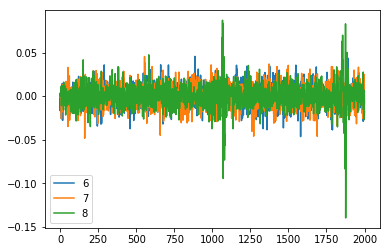

In [258]:
for k in [6,7,8]:
    plt.plot(targets[window, k], label=k)
plt.legend()

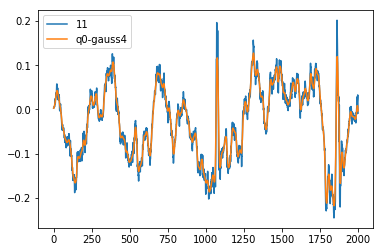

In [259]:
dat = inputs
idx=11
for k in [idx]:
    plt.plot(dat[window,k], label=k)
q0_s=smoothen_gauss(dat[:,idx],4)
plt.plot(q0_s[window], label='q0-gauss4')
plt.legend()

## export dataset for Eurequa and old EQL

In [30]:
import dill

In [31]:
train,val = load_training("Dataset/dataset_v03_training.npz", hist_len=10, horizon=1)

(120, 19000, 9)
96 24
[  1   2   3   5   6   7   8   9  12  13  14  15  16  17  19  20  21  22
  23  24  25  27  28  29  30  32  33  34  35  37  38  39  41  42  43  46
  48  49  50  51  52  53  54  56  57  58  59  60  61  63  66  67  68  69
  71  72  74  75  76  77  78  79  80  81  82  83  84  85  86  87  90  92
  93  94  95  96  97  98  99 100 101 102 103 105 106 108 110 111 112 113
 114 115 116 117 118 119]
Train Inputs: (1823040, 120)
Train Targets: (1823040, 9)
Val Inputs: (455760, 120)
Val Targets: (455760, 9)


In [32]:
inputs_raw = train[0]
targets_raw = train[1]

In [33]:
input_stdizer = standardizer.Standardizer(data=inputs_raw)
inputs = input_stdizer.standardize(inputs_raw)

target_stdizer = standardizer.Standardizer(data=targets_raw)
targets = target_stdizer.standardize(targets_raw)

In [34]:
stats(targets)

{'len': 1823040,
 'mean': array([ 3.24642298e-14, -5.28314489e-15,  7.88345858e-15,  3.56989722e-15,
         2.51328089e-16,  1.77255090e-15,  1.60522669e-17, -3.37078969e-19,
         6.83408275e-17]),
 'std': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'min': array([-17.12555259, -18.45726297, -24.59795924, -48.93325493,
        -33.18418719, -26.44612336, -55.01475166, -30.88310963,
        -31.26060379]),
 'max': array([19.93199499, 18.16725989, 24.03694792, 42.5452217 , 39.54595926,
        26.81380211, 39.81017368, 36.55513586, 31.99197693])}

In [35]:
inputs_val, targets_val = (input_stdizer.standardize(val[0]),target_stdizer.standardize(val[1]))

In [36]:
dill.dump(((inputs,targets),(inputs_val, targets_val),()), open("Dataset/dataset_v03_hist10-h1-split.dat", "wb"), protocol=2)

In [37]:
pickle.dump((input_stdizer, target_stdizer),open("Dataset/dataset_v03_hist10-h1-standarizers.dat","wb"), protocol=2)

## compute averages over old states and actions

In [53]:
train,val = load_training("Dataset/dataset_v03_training.npz", hist_len=10, horizon=1, average=True)

(120, 19000, 9)
96 24
[  1   2   3   5   6   7   8   9  12  13  14  15  16  17  19  20  21  22
  23  24  25  27  28  29  30  32  33  34  35  37  38  39  41  42  43  46
  48  49  50  51  52  53  54  56  57  58  59  60  61  63  66  67  68  69
  71  72  74  75  76  77  78  79  80  81  82  83  84  85  86  87  90  92
  93  94  95  96  97  98  99 100 101 102 103 105 106 108 110 111 112 113
 114 115 116 117 118 119]
Train Inputs: (1823040, 12)
Train Targets: (1823040, 9)
Val Inputs: (455760, 12)
Val Targets: (455760, 9)


In [54]:
inputs = train[0]

In [55]:
rollout = 30
window = slice(rollout,1000*96+rollout, 96)
def shift_slice(s, n):
    return slice(s.start+n, s.stop+n, s.step)

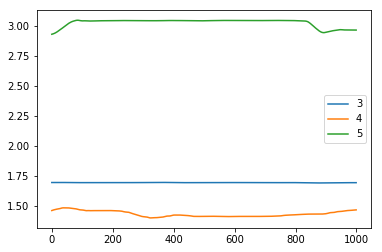

In [56]:
for k in [3,4,5]:
    plt.plot(inputs[window, k], label=k)
plt.legend()

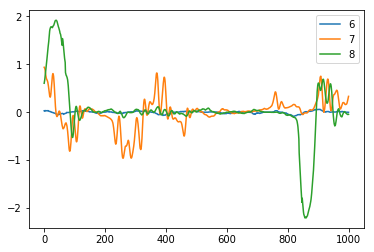

In [57]:
for k in [6,7,8]:
    plt.plot(inputs[window, k], label=k)
plt.legend()

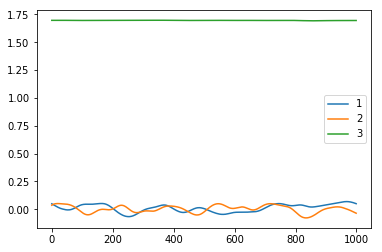

In [58]:
for k in [1,2,3,]:
    plt.plot(inputs[window, k], label=k)
plt.legend()

In [59]:
inputs_raw = train[0]
targets_raw = train[1]

In [60]:
input_stdizer = standardizer.Standardizer(data=inputs_raw)
inputs = input_stdizer.standardize(inputs_raw)

target_stdizer = standardizer.Standardizer(data=targets_raw)
targets = target_stdizer.standardize(targets_raw)

In [61]:
stats(targets)

{'len': 1823040,
 'mean': array([ 3.24642298e-14, -5.28314489e-15,  7.88345858e-15,  3.56989722e-15,
         2.51328089e-16,  1.77255090e-15,  1.60522669e-17, -3.37078969e-19,
         6.83408275e-17]),
 'std': array([1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 'min': array([-17.12555259, -18.45726297, -24.59795924, -48.93325493,
        -33.18418719, -26.44612336, -55.01475166, -30.88310963,
        -31.26060379]),
 'max': array([19.93199499, 18.16725989, 24.03694792, 42.5452217 , 39.54595926,
        26.81380211, 39.81017368, 36.55513586, 31.99197693])}

In [62]:
inputs_val, targets_val = (input_stdizer.standardize(val[0]),target_stdizer.standardize(val[1]))

In [65]:
pickle.dump(((inputs,targets),(inputs_val, targets_val),()), open("Dataset/dataset_v03_hist10avg-h1-split.dat", "wb"), protocol=2)

In [50]:
pickle.dump((input_stdizer, target_stdizer), open("Dataset/dataset_v03_hist10avg-h1-standarizers.dat","wb"), protocol=2)

In [51]:
columns = " ".join(["a1","a2","a3","o1","o2","o3","o4","o5","o6", "o7","o8","o9", "t1","t2","t3","t4","t5","t6", "t7","t8","t9"])

In [52]:
np.savetxt("Dataset/dataset_v03_hist10avg-h1-4eureqa.csv", np.concatenate([inputs, targets], axis=1)[::10], header=columns, comments='')

# Linear Baseline

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X = train[0]
y = train[1]
reg = LinearRegression().fit(X, y)
reg.score(X, y)

In [102]:
pred = reg.predict(np.vstack(test[0]))
np.mean([np.linalg.norm(x) for x in pred - test[1]])

0.26617980379617817

In [412]:
X.shape

(3599820, 12)

# Evaluations

In [46]:
input_stdizer, target_stdizer = pickle.load(open("Dataset/dataset_v02_standarizers.dat","rb"))